## 1. 모듈 불러오고 장비 확인

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import random
from torchsummary import summary

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('using pytorch version : ',torch.__version__, '   device : ',DEVICE)

using pytorch version :  1.7.0+cu101    device :  cuda


#### 필요한 값 설정

In [3]:
seed = 777
random.seed(seed)
torch.manual_seed(seed)
if DEVICE == 'cuda':
    torch.cuda.manual_seed_all(seed)
    
BATCH_SIZE = 100
EPOCHS = 42

# 하이퍼파라미터 설정
learning_rate = 0.0015
momentum = 0
weight_decay = 1e-4

## 2. 데이터 셋 준비

이미지 데이터가 클래스 별로 폴더안에 들어있다 가정.

In [4]:
path = './dataset' # 불러올 데이터셋 경로

# 폴더 안의 이미지 데이터 불러오기
dataset = datasets.ImageFolder(root = path,
                              transform = transforms.Compose([
                                  transforms.Resize((224,224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.4, 0.4, 0.4], [0.2, 0.2, 0.2])
                              ])) 

# train/test 분리. 사이킷런 train_test_split & torch.utils.data의 Subset 활용
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size = 0.1, random_state = seed)
print("train index : ", train_idx)
print("\ntest index : ", test_idx)

train index :  [1085, 3924, 399, 1180, 1549, 3162, 667, 840, 46, 2807, 173, 3284, 2972, 3200, 1645, 1071, 2367, 1082, 471, 3345, 2734, 274, 3153, 2821, 1086, 95, 3814, 1658, 1220, 187, 3859, 1107, 3254, 3263, 3240, 993, 3257, 2844, 1286, 1764, 533, 2317, 3945, 3564, 1141, 3536, 2699, 1514, 366, 717, 2346, 2035, 3530, 2532, 1711, 2910, 1758, 3012, 1, 193, 1568, 3366, 2038, 37, 1387, 935, 2199, 26, 2652, 284, 1451, 1113, 2688, 859, 1429, 3569, 1818, 1605, 196, 3944, 3205, 530, 189, 621, 866, 3443, 1952, 2085, 1195, 3214, 280, 3997, 3875, 2330, 3900, 2204, 3761, 3804, 2185, 1969, 2967, 3266, 3419, 1503, 2248, 3389, 1557, 952, 540, 3777, 1746, 2257, 2303, 3510, 192, 1313, 1888, 2769, 1854, 1739, 929, 3791, 2882, 177, 2684, 760, 2573, 254, 2466, 3990, 3649, 2051, 3593, 2172, 3035, 552, 2905, 2766, 3054, 2321, 3951, 1988, 563, 1698, 2096, 50, 1321, 431, 2136, 315, 3775, 2943, 2191, 3947, 3479, 3070, 3480, 2893, 1109, 693, 2965, 343, 1206, 1592, 3956, 2222, 3585, 460, 964, 521, 3632, 403, 267

In [5]:
from torch.utils.data import Subset, DataLoader
train_data = Subset(dataset, train_idx)
test_data = Subset(dataset, test_idx)

# 학습/평가용 데이터 생성 완료
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False)

In [6]:
# 데이터 확인
print("학습 전체 데이터 셋 : ",len(train_loader.dataset))
print("학습 배치 묶음 개수 : ", len(train_loader))

print("\n평가 전체 데이터 셋 : ",len(test_loader.dataset))
print("평가 배치 묶음 개수 : ", len(test_loader))

학습 전체 데이터 셋 :  3600
학습 배치 묶음 개수 :  36

평가 전체 데이터 셋 :  400
평가 배치 묶음 개수 :  4


In [7]:
# train_loader
for image, label in train_loader:
    print(image.size(), image.type())
    print(image[0])
    print(label.size(), label.type())
    break

torch.Size([100, 3, 224, 224]) torch.FloatTensor
tensor([[[ 1.4118,  1.4118,  1.4118,  ...,  2.0784,  2.0784,  2.0784],
         [ 1.4118,  1.4118,  1.4118,  ...,  2.0784,  2.0784,  2.0784],
         [ 1.4118,  1.4118,  1.4118,  ...,  2.0588,  2.0588,  2.0588],
         ...,
         [ 0.6078,  0.6078,  0.6667,  ...,  0.3137,  0.2941,  0.3725],
         [ 0.5686,  0.5686,  0.5882,  ...,  0.2745,  0.2549,  0.3333],
         [ 0.2941,  0.2745,  0.2941,  ...,  0.0000,  0.0000,  0.0980]],

        [[ 1.1961,  1.1961,  1.1961,  ...,  2.0784,  2.0784,  2.0784],
         [ 1.1961,  1.1961,  1.1961,  ...,  2.0784,  2.0784,  2.0784],
         [ 1.1961,  1.1961,  1.1961,  ...,  2.0588,  2.0588,  2.0588],
         ...,
         [ 0.5098,  0.5098,  0.5490,  ...,  0.1176,  0.0980,  0.1765],
         [ 0.4510,  0.4510,  0.4706,  ...,  0.0784,  0.0588,  0.1373],
         [ 0.1765,  0.1569,  0.1765,  ..., -0.1961, -0.1961, -0.0980]],

        [[ 0.8039,  0.8039,  0.8039,  ...,  1.8431,  1.8431,  1.843

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

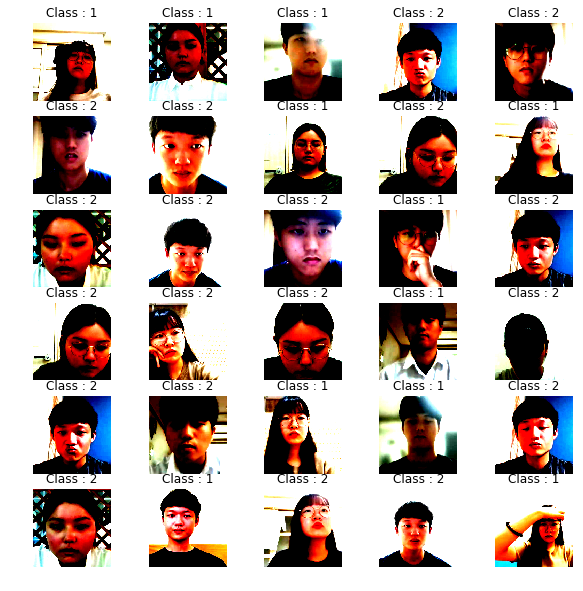

In [8]:
# train_loader의 한 배치로 묶여있는 이미지 중 50장 출력해보기
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize = (10,10))
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(image[i],(1,2,0))) # (층,행,열) -> (행,열,층)
    plt.title('Class : '+ str(label[i].item()))

## 3. Pretrained 된 모델/optimizer/loss function 불러오기

In [9]:
import torchvision.models as models
model = models.resnet18(pretrained = True)
# model = models.resnet34(pretrained = False)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss_function = torch.nn.CrossEntropyLoss() # 혹은 BCELoss

In [10]:
## 모델 확인
model = model.to(DEVICE)
summary(model, input_size=(3,224,224)) # (channels, H, W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#### train 데이터에 대한 모델 성능을 확인하는 함수

In [11]:
batch_train_loss = [] # train 과정에서의 loss 값들을 저장할 리스트
train_loss_list = [] # 에폭별 평균 loss 값 저장할 리스트
def train(model, train_loader, optimizer, log_interval) :
    average_cost = 0 # 각 에폭별 평균 loss 구하기
    model.train()
    print('================== T R A I N I N G . . . ==================')
    print("                        EPOCH {}                  ".format(epoch))
    for idx, (img,label) in enumerate(train_loader) :
        num_of_mini_batch = len(train_loader)
        img = img.to(DEVICE)
        label = label - 1
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(img)
        loss = loss_function(output,label)
        loss.backward()
        optimizer.step()
        
        batch_train_loss.append(loss) # 미니배치 한 묶음에 대한 평균 loss를 리스트에 저장
        average_cost = average_cost + (loss.item()/num_of_mini_batch) # 에폭마다 평균 loss를 구하기 위한 과정
        # loss.item()은 loss가 연산가능하게끔 torch.Tensor 형에서 float로 바꾸어줌
        
        # 결과 출력
        if idx % log_interval == 0:
            print("[{}/{}]({:.0f}%)   Train Loss : {:.6f} ".format(idx*BATCH_SIZE, 
                                                               len(train_loader.dataset),
                                                               100.*idx / num_of_mini_batch,
                                                               loss.item()))
    train_loss_list.append(average_cost)
    print('============================================================')
    

#### test 데이터에 대한 모델 성능을 확인하는 함수

In [12]:
test_loss_list = [] # 각 에폭별 test 데이터에 대한 평균 loss
test_accuracy_list = [] # 각 에폭별 test 데이터에 대한 accuracy 모을 리스트
def evaluate(model, test_loader):
    model.eval()
    num_of_mini_batch = len(test_loader)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader :
            image = image.to(DEVICE)
            label = label - 1
            label = label.to(DEVICE)
            output = model(image)
            # 각 배치별 평균 loss 값을 저장
            loss = loss_function(output,label)
            test_loss += loss.item()
            # 가장 큰 확률을 가진 클래스로 예측값 결정
            prediction = output.max(1, keepdim = True)[1]
            # 예측값과 실제값이 동일한 경우 카운트
            correct += prediction.eq(label.view_as(prediction)).sum().item()
                
        test_loss /= num_of_mini_batch
        test_accuracy = 100. * correct / len(test_loader.dataset)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        
        return test_loss, test_accuracy

## 4. 모델 학습 및 평가

In [13]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 6)
    test_loss, test_accuracy =  evaluate(model, test_loader)
    print("\nTest Epoch:{}\tTest Loss:{:.4f}\tTest Accracy:{:.2f}% \n ".format(epoch,test_loss,test_accuracy))

================== T R A I N I N G . . . ==================
                        EPOCH 1                  
[0/3600](0%)   Train Loss : 0.688153 
[600/3600](17%)   Train Loss : 0.700017 
[1200/3600](33%)   Train Loss : 0.714409 
[1800/3600](50%)   Train Loss : 0.627341 
[2400/3600](67%)   Train Loss : 0.567006 
[3000/3600](83%)   Train Loss : 0.619374 

Test Epoch:1	Test Loss:0.5603	Test Accracy:76.00% 
 
================== T R A I N I N G . . . ==================
                        EPOCH 2                  
[0/3600](0%)   Train Loss : 0.574715 
[600/3600](17%)   Train Loss : 0.515877 
[1200/3600](33%)   Train Loss : 0.543547 
[1800/3600](50%)   Train Loss : 0.532419 
[2400/3600](67%)   Train Loss : 0.455242 
[3000/3600](83%)   Train Loss : 0.491269 

Test Epoch:2	Test Loss:0.4808	Test Accracy:81.50% 
 
================== T R A I N I N G . . . ==================
                        EPOCH 3                  
[0/3600](0%)   Train Loss : 0.559679 
[600/3600](17%)   Train Loss :

[1200/3600](33%)   Train Loss : 0.231574 
[1800/3600](50%)   Train Loss : 0.220511 
[2400/3600](67%)   Train Loss : 0.154892 
[3000/3600](83%)   Train Loss : 0.182949 

Test Epoch:18	Test Loss:0.2501	Test Accracy:90.00% 
 
================== T R A I N I N G . . . ==================
                        EPOCH 19                  
[0/3600](0%)   Train Loss : 0.159761 
[600/3600](17%)   Train Loss : 0.213401 
[1200/3600](33%)   Train Loss : 0.176119 
[1800/3600](50%)   Train Loss : 0.271864 
[2400/3600](67%)   Train Loss : 0.220231 
[3000/3600](83%)   Train Loss : 0.176302 

Test Epoch:19	Test Loss:0.2462	Test Accracy:89.75% 
 
================== T R A I N I N G . . . ==================
                        EPOCH 20                  
[0/3600](0%)   Train Loss : 0.265155 
[600/3600](17%)   Train Loss : 0.196836 
[1200/3600](33%)   Train Loss : 0.195943 
[1800/3600](50%)   Train Loss : 0.190147 
[2400/3600](67%)   Train Loss : 0.175841 
[3000/3600](83%)   Train Loss : 0.213246 

Test 


Test Epoch:35	Test Loss:0.2185	Test Accracy:90.75% 
 
================== T R A I N I N G . . . ==================
                        EPOCH 36                  
[0/3600](0%)   Train Loss : 0.118428 
[600/3600](17%)   Train Loss : 0.132005 
[1200/3600](33%)   Train Loss : 0.151273 
[1800/3600](50%)   Train Loss : 0.108406 
[2400/3600](67%)   Train Loss : 0.138872 
[3000/3600](83%)   Train Loss : 0.078357 

Test Epoch:36	Test Loss:0.2174	Test Accracy:91.50% 
 
================== T R A I N I N G . . . ==================
                        EPOCH 37                  
[0/3600](0%)   Train Loss : 0.064131 
[600/3600](17%)   Train Loss : 0.120220 
[1200/3600](33%)   Train Loss : 0.104134 
[1800/3600](50%)   Train Loss : 0.086509 
[2400/3600](67%)   Train Loss : 0.117637 
[3000/3600](83%)   Train Loss : 0.101201 

Test Epoch:37	Test Loss:0.2178	Test Accracy:91.00% 
 
================== T R A I N I N G . . . ==================
                        EPOCH 38                  
[0/3600]

### plotting

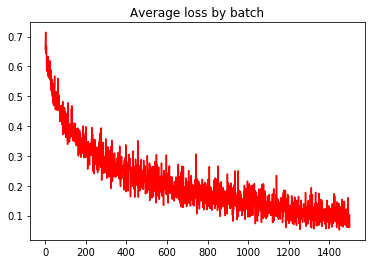

In [16]:
# print(batch_train_loss[:10])
plt.title('Average loss by batch')
plt.plot(np.array(batch_train_loss[10:]), 'r')

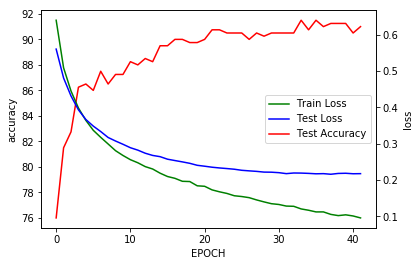

In [15]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
g1 = ax2.plot(train_loss_list, color = 'green', label = 'Train Loss')
g2 = ax2.plot(test_loss_list, color = 'blue', label = 'Test Loss')
g3 = ax.plot(test_accuracy_list, color = 'red', label = 'Test Accuracy')

ax2.set_ylabel('loss')
ax.set_ylabel('accuracy')
ax.set_xlabel('EPOCH')

g = g1 + g2 + g3
labels = [l.get_label() for l in g]
ax.legend(g,labels, loc = 'right')
plt.show()